In [1]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

### Library

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import renom as rm
from renom.optimizer import Adam
from renom.cuda import set_cuda_active
# if you would like to use GPU, set True, otherwise you should be set to False
set_cuda_active(False)

In [83]:
def create_dataset(data, look_back):
    exp = []
    target = []
    for i in range(len(data)-look_back):
        exp.append(data[i : i+look_back, :])
        target.append(data[i + look_back,9])
    n_features = np.array(exp).shape[2]
    exp = np.array(exp)
    target = np.array(target).reshape(-1,1)
    return exp, target

In [4]:
def split_data(X, y, test_size=0.1):
    pos = int(round(len(X) * (1-test_size)))
    X_train, y_train = X[:pos], y[:pos]
    X_test, y_test = X[pos:], y[pos:]
    return X_train, y_train, X_test, y_test

In [126]:
with open('../intermediate_data/prep_data.pickle', mode='rb') as f:
    df = pickle.load(f)

In [147]:
sc = StandardScaler()
df_std = sc.fit_transform(df)

In [148]:
X, y = create_dataset(df_std, 20)

In [149]:
X_train, y_train, X_test, y_test = split_data(X, y)

In [150]:
X_train.shape

(4412, 20, 33)

In [152]:
sequential = rm.Sequential([
    rm.Lstm(30),
    rm.Lstm(10),
    rm.Dense(1)
])

In [153]:
batch_size = 100
epoch = 1
N = len(X_train)
T = X_train.shape[1]

learning_curve = []
test_learning_curve = []
optimizer = Adam(lr=0.001)
for i in range(epoch):
    loss = 0
    test_loss = 0
    perm = np.random.permutation(N)
    for j in range(N//batch_size):
        train_batch = X_train[perm[j*batch_size : (j+1)*batch_size]]
        response_batch = y_train[perm[j*batch_size : (j+1)*batch_size]]
        l = 0
        with sequential.train():
            for t in range(T):
                z = sequential(train_batch[:, t, :])
                l = rm.mse(z, response_batch)
            sequential.truncate()
        l.grad().update(optimizer)
        loss += l.as_ndarray()
    loss = loss / (N // batch_size)
    l_test = 0
    for t in range(T):
        z = sequential(X_test[:, t, :])
        l_test = rm.mse(z, y_test)
    sequential.truncate()
    test_loss += l_test.as_ndarray()
    if i % 10 == 0:
        print("epoch:{:04d} loss:{:.5f} test_loss:{:.5f}".format(i, loss, test_loss))
    learning_curve.append(loss)
    test_learning_curve.append(test_loss)

epoch:0000 loss:0.50811 test_loss:0.46722


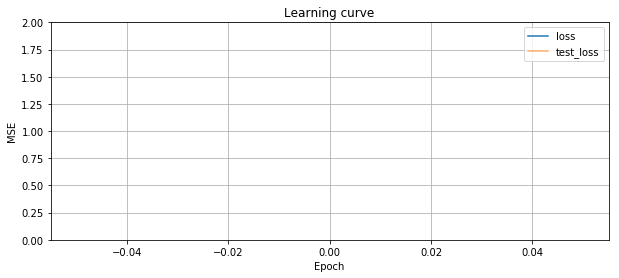

In [154]:
plt.figure(figsize=(10, 4))
plt.plot(learning_curve, label='loss')
plt.plot(test_learning_curve, label='test_loss', alpha=0.6)
plt.title('Learning curve')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.ylim(0, 2)
plt.legend()
plt.grid()

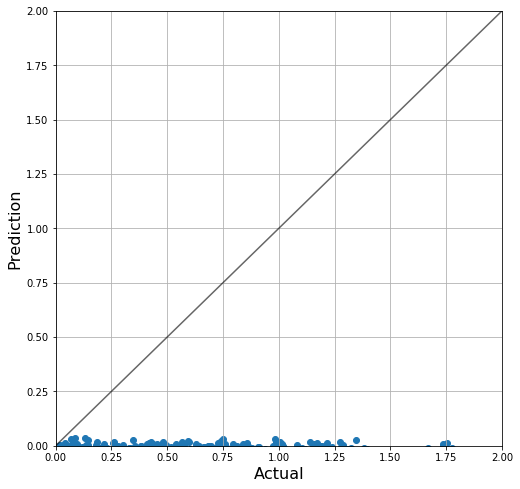

In [157]:
# predict test value
# y_train_pred = sequential(X_train[:, t, :])
y_test_pred = sequential(X_test[:, t, :])

# # convert standardized heating-load to its original unit
# true = y_test[:, 0].reshape(-1, 1) * v_std + v_mean
# pred = y_pred * v_std + v_mean

plt.figure(figsize=(8, 8))
plt.plot([0, 2], [0, 2], c='k', alpha=0.6) # diagonal line
# plt.scatter(y_train, y_train_pred)
plt.scatter(y_test, y_test_pred)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel('Actual', fontsize=16)
plt.ylabel('Prediction', fontsize=16)
plt.grid()